# Bond Market Index Components and Interest Rate Indicators

- PCA, St Louis Fed FRED

Terence Lim

In [6]:
import os
import re
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
from finds.alfred import Alfred, marginalR2
from settings import settings
imgdir = os.path.join(settings['images'], 'ts')
alf = Alfred(api_key=settings['fred']['api_key'])


In [7]:
# get Merrill Lynch bond indexes
c = alf.get_category(32413)
print(c['id'], c['name'])
t = Series({s['id']: s['title'] for s in c['series']})

bonds = [alf(s, start=19961231) for s in t.index]
b = pd.concat(bonds, axis=1)

# Show blocks of data available
v = b.notna().sum(axis=1).rename('count')
v = pd.concat([v, (v != v.shift()).cumsum().rename('notna')], axis=1)
g = v.reset_index().groupby(['notna', 'count'])['date'].agg(['first','last'])
g

32413 BofA Merrill Lynch Total Bond Return Index Values


,,first,last
notna,count,,
1,15,19961231,19971230
2,16,19971231,19981230
3,33,19981231,20031230
4,48,20031231,20181108
5,46,20181109,20181109
6,48,20181112,20210308


## Require data available since 19981231, take log return and principal components

In [8]:
start_date = 19981231
rets = b.loc[b.index >= start_date, b.loc[start_date].notna().values]
rets = pd.concat([alf.transform(rets[col], log=1, diff=1)
                  for col in rets.columns], axis=1)
t = Series([alf.header(col) for col in rets.columns], index=rets.columns)
t.to_frame()

,0
BAMLCC0A0CMTRIV,ICE BofA US Corporate Index Total Return Index...
BAMLCC0A1AAATRIV,ICE BofA AAA US Corporate Index Total Return I...
BAMLCC0A2AATRIV,ICE BofA AA US Corporate Index Total Return In...
BAMLCC0A3ATRIV,ICE BofA Single-A US Corporate Index Total Ret...
BAMLCC0A4BBBTRIV,ICE BofA BBB US Corporate Index Total Return I...
BAMLCC1A013YTRIV,ICE BofA 1-3 Year US Corporate Index Total Ret...
BAMLCC2A035YTRIV,ICE BofA 3-5 Year US Corporate Index Total Ret...
BAMLCC3A057YTRIV,ICE BofA 5-7 Year US Corporate Index Total Ret...
BAMLCC4A0710YTRIV,ICE BofA 7-10 Year US Corporate Index Total Re...
BAMLCC7A01015YTRIV,ICE BofA 10-15 Year US Corporate Index Total R...


## Marginal Variance Explained

In [12]:
x = np.array(rets.iloc[1:])
d = rets.iloc[1:].index.rename(None)
c = rets.columns
mR2 = marginalR2(x, standardize=True)
r = 4
print(f"Explained by {r} factors: {np.sum(np.mean(mR2[:r,:], axis=1)):.3f}"
      f" ({len(x)} obs)")
df = DataFrame({'explained': np.mean(mR2, axis=1)},
               index=np.arange(1, len(mR2) + 1))
df.iloc[:4].T

Explained by 4 factors: 0.873 (5793 obs)


,1,2,3,4
explained,0.580697,0.19444,0.075371,0.022922


## Same calculation with sklearn

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(r))])
pipe.fit(x)
pipe.named_steps['pca'].explained_variance_ratio_  # sanity check

array([0.58069685, 0.19444038, 0.07537078, 0.02292225])

## Scree plot

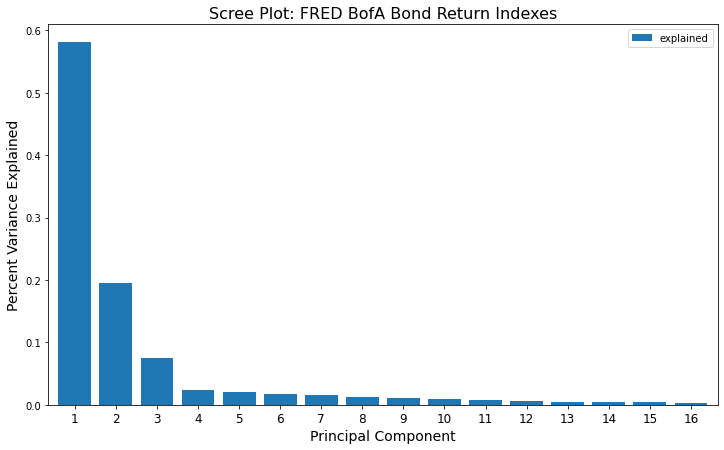

In [14]:
fig, ax = plt.subplots(num=1, clear=True, figsize=(12, 7))
df[:len(mR2)//2].plot(kind='bar', rot=0, width=.8, ax=ax)
ax.set_title('Scree Plot: FRED BofA Bond Return Indexes', fontsize=16)
ax.xaxis.set_tick_params(labelsize=12)
ax.set_ylabel("Percent Variance Explained", fontsize=14)
ax.set_xlabel("Principal Component", fontsize=14)
plt.savefig(os.path.join(imgdir, 'scree.jpg'))
plt.show()

## Plot of factor estimates compared to levels of selected interest rates

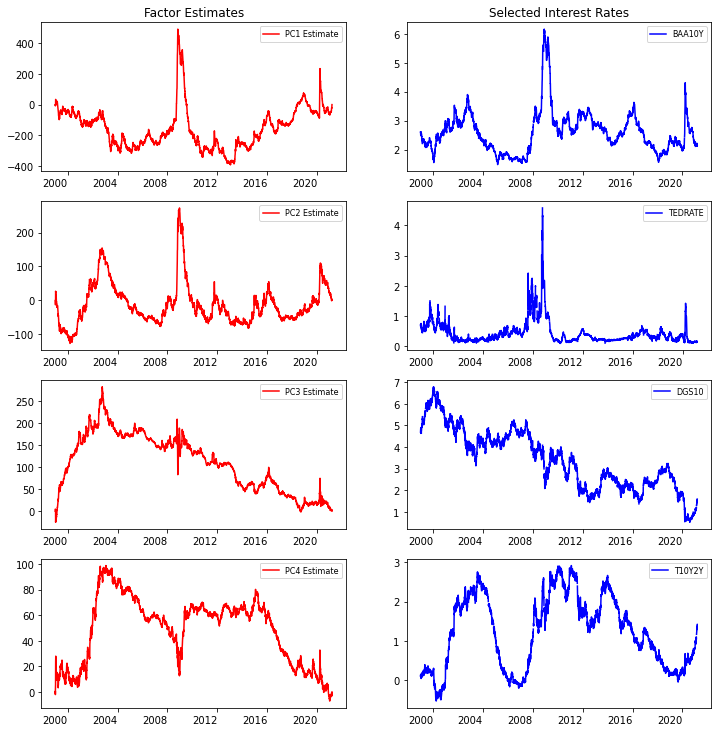

In [15]:
factors = DataFrame(pipe.transform(x), columns=np.arange(1, 1+r),
                    index=pd.DatetimeIndex(d.astype(str), freq='infer'))
fig = plt.figure(figsize=(12,14), num=1, clear=True)
for isub, col in enumerate(factors.columns):
    ax = fig.add_subplot(r, 2, (col * 2) - 1)
    flip = -1 if col == 3 else 1
    (flip*factors[col]).cumsum().plot(ax=ax, color='r')
    ax.legend([f"PC{col} Estimate"], fontsize=8)
    ax.xaxis.set_tick_params(rotation=0)
    if not isub:
        ax.set_title('Factor Estimates')
        
rates = ['BAA10Y', 'TEDRATE', 'DGS10', 'T10Y2Y']  # compare rate levels
spreads = pd.concat([alf(s) for s in rates], axis=1).reindex(d)
spreads.index = pd.DatetimeIndex(spreads.index.astype(str), freq='infer')
spreads.index.name
for isub, col in enumerate(spreads.columns):
    ax = fig.add_subplot(r, 2, (isub + 1) * 2)
    spreads[col].plot(ax=ax, color='b')
    ax.legend([col], fontsize=8)
    ax.xaxis.set_tick_params(rotation=0)
    if not isub:
        ax.set_title('Selected Interest Rates')
plt.savefig(os.path.join(imgdir, 'components.jpg'))        
plt.show()
